In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
from DistInference.general_utils import analyze_input, grid_image_show, histogram_plotter, print_module_summary, set_module_grad, save_dict_pickle, heatmap_show
from DistInference.tcm import TCM
import numpy as np

/project_ghent/Mostafa/image/compress_AI/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def tcm_loader(checkpoint, net):
    checkpoint = torch.load(checkpoint, map_location=device)
    
    dictory = {}
    for k, v in checkpoint["state_dict"].items():
        dictory[k.replace("module.", "")] = v
    net.load_state_dict(dictory)
    return net


N = 64
lambda_value = "0_05" # 0_0025 0_05


device = 'cuda'

# TCM
checkpoint = f"/project_ghent/Mostafa/image/ImageTransmission/src/gen_comm/lic_tcm/LIC_TCM/mse_lambda_{lambda_value}_N{N}.pth"
# checkpoint = f"/project_ghent/Mostafa/image/ImageTransmission/src/gen_comm/lic_tcm/LIC_TCM/pths/20240926_063733.pth.tar"
# checkpoint = f"/project_ghent/Mostafa/image/ImageTransmission/src/gen_comm/lic_tcm/LIC_TCM/checkpointscheckpoint_latest.pth.tar"
tcm = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=N, M=320)
# tcm.num_slices=192
tcm = tcm_loader(checkpoint, tcm)
tcm.cuda()
tcm.update()

/tmp/ipykernel_59018/949917730.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint, map_location=device)


No Description Passed!:
  - Shape: torch.Size([64])
  - Dtype: torch.float32
  - Value range: 0.10999999940395355 to 256.0
  - Unique values as a fraction of total: 1.0000
  - Number of elements: 64
  - Number of unique values: 64
  - Entropy: Only Defined for Integers! bits per element
  - A few sample values: [0.10999999940395355, 0.12440409511327744, 0.14069437980651855, 0.15911780297756195, 0.1799536943435669]
  - Size: 0.0002 MB



True

In [4]:
img = torch.rand(1, 3, 64, 64).cuda()

z = tcm.g_a(img)
img_hat = tcm.g_s(z).clamp_(0, 1)

# psnr = compute_metrics(img, img_hat)['psnr']
# print(psnr)
print(z.shape)
# grid_image_show([img, img_hat], scale=.5)

file_path = '/project_ghent/Mostafa/ActivityRecognition/1 December 2017 Dataset/2P54A02R01.dat'

# Read the file content
with open(file_path, 'r') as file:
    content = file.read()

# Split the content into lines
lines = content.strip().split('\n')

# Extract metadata (first four lines)
metadata = {
    'carrier_frequency_GHz': float(lines[0]),
    'chirp_duration_ms': float(lines[1]),
    'samples_per_beat_note': int(float(lines[2])),
    'bandwidth_MHz': float(lines[3])
}

# Extract data (remaining lines)
data_lines = lines[4:]

# Function to convert a line to a complex number
def parse_complex(line):
    line = line.replace('i', 'j').replace('I', 'j')  # Replace 'i' with 'j' for Python
    try:
        return complex(line)
    except ValueError:
        return None  # or handle differently if needed

# Parse all data lines into complex numbers, filtering out invalid entries
complex_samples = [parse_complex(line) for line in data_lines]
complex_samples = [sample for sample in complex_samples if sample is not None]


# Convert to a NumPy array
complex_samples = np.array(complex_samples)

# Optionally, reshape into beat-note signals if samples_per_beat_note > 0
samples_per_beat = metadata['samples_per_beat_note']

total_samples = len(complex_samples)
total_beat_notes = total_samples // samples_per_beat
if total_beat_notes == 0:
    raise ValueError("Number of samples per beat-note is larger than total samples.")
# Trim excess samples
complex_samples = complex_samples[:total_beat_notes * samples_per_beat]
# Reshape
beat_notes = complex_samples.reshape((total_beat_notes, samples_per_beat))


####################
from scipy.signal import stft

# --- Step 1: Extract Metadata ---
samples_per_chirp = metadata['samples_per_beat_note']//1
chirp_duration_ms = metadata['chirp_duration_ms']  # in milliseconds
prf = 1 / (chirp_duration_ms * 1e-3)  # Pulse Repetition Frequency in Hz
bandwidth_hz = metadata['bandwidth_MHz'] * 1e6  # Convert MHz to Hz
carrier_freq_hz = metadata['carrier_frequency_GHz'] * 1e9  # Convert GHz to Hz

num_chirps = total_samples // samples_per_chirp

# Reshape to 2D array: (num_chirps x samples_per_chirp)
complex_data = complex_samples.reshape((num_chirps, samples_per_chirp))

slow_time_signal = np.mean(complex_data, axis=1)

# Remove DC component to avoid spectral leakage
slow_time_signal -= np.mean(slow_time_signal)



window_size, overlap = 128, 64


# --- Step 6: Perform STFT on Slow-Time Signal ---
# The sampling frequency for slow-time is PRF
f, t_stft, Zxx = stft(
    slow_time_signal,
    fs=prf,
    window='hann',
    nperseg=window_size,
    noverlap=overlap,
    nfft=window_size*2,  # Increase nfft for better frequency resolution
    return_onesided=False  # To obtain both negative and positive frequencies
)

# --- Step 7: Shift STFT Output to Center Zero Frequency ---
Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
f_shifted = np.fft.fftshift(f)

torch.Size([1, 320, 4, 4])


In [5]:
import torch.nn.functional as F

# Compute magnitude and phase
magnitude = np.abs(Zxx_shifted)
phase = np.angle(Zxx_shifted)

# Normalize magnitude to [0, 1]
magnitude_normalized = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-10)

# Normalize phase to [0, 1]
phase_normalized = (phase + np.pi) / (2 * np.pi)

# Logarithmic magnitude (optional for Channel 3)
log_magnitude = np.log1p(magnitude)
log_magnitude_normalized = (log_magnitude - log_magnitude.min()) / (log_magnitude.max() - log_magnitude.min() + 1e-10)

# Stack into channels
# stft_3d = np.stack([magnitude_normalized, phase_normalized, log_magnitude_normalized], axis=-1)
stft_3d = torch.tensor(np.stack([magnitude_normalized, magnitude_normalized, magnitude_normalized], axis=0)).unsqueeze(0)
print(stft_3d.shape)

pad_h, pad_w = (64 - stft_3d.size(2) % 64) % 64, (64 - stft_3d.size(3) % 64) % 64

# Apply padding
stft_3d_padded = F.pad(stft_3d, (0, pad_w, 0, pad_h)).float().cuda()

# Print and store padding values
print(f"Padded Height: {pad_h}, Padded Width: {pad_w}")
print("Original Size:", stft_3d.size(), "Padded Size:", stft_3d_padded.size())

print(stft_3d_padded.shape)


torch.Size([1, 3, 256, 80])
Padded Height: 0, Padded Width: 48
Original Size: torch.Size([1, 3, 256, 80]) Padded Size: torch.Size([1, 3, 256, 128])
torch.Size([1, 3, 256, 128])


In [6]:
# Pass through compression model
z_magnitude_db = tcm.g_a(stft_3d_padded)
stft_3d_padded_hat = tcm.g_s(z_magnitude_db)

Mean Squared Error (MSE): 6.127851520432159e-06
Mean Absolute Error (MAE): 0.0014833915047347546
Peak Signal-to-Noise Ratio (PSNR): 52.12691783905029 dB


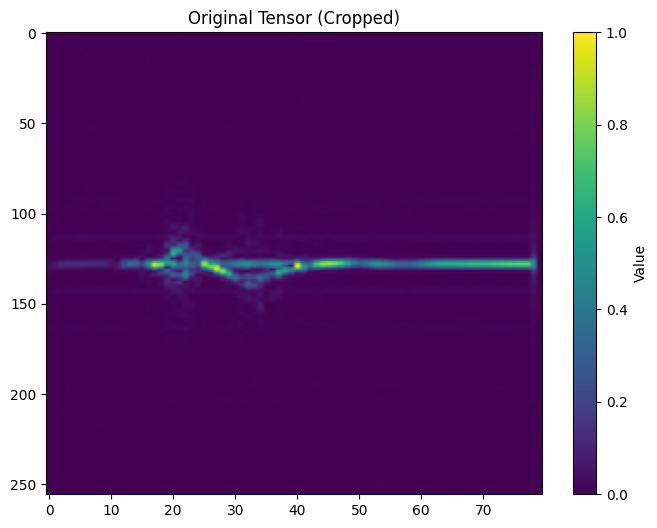

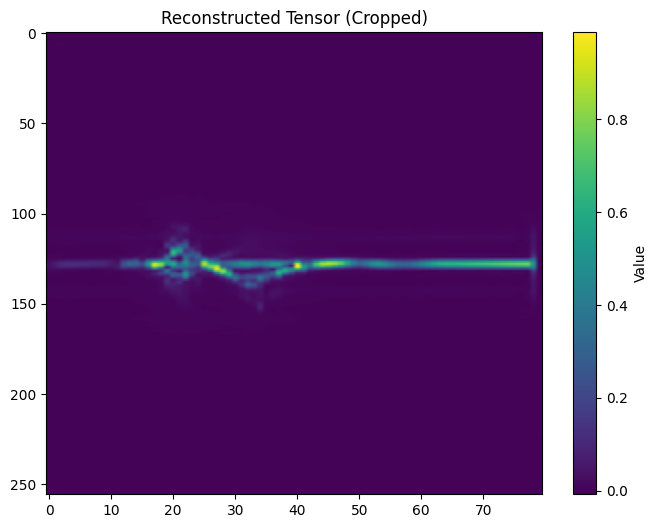

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Example tensors (padded original and reconstructed)
original = stft_3d_padded[0][0].cpu().detach().numpy()  # Original padded
reconstructed = stft_3d_padded_hat[0][0].cpu().detach().numpy()  # Reconstructed padded

# Original dimensions before padding
original_height, original_width = 256, 80  # Replace with your original dimensions

# Remove zero padding by cropping to original dimensions
original_cropped = original[:original_height, :original_width]
reconstructed_cropped = reconstructed[:original_height, :original_width]

# Compute error metrics
mse = np.mean((original_cropped - reconstructed_cropped) ** 2)
mae = np.mean(np.abs(original_cropped - reconstructed_cropped))
psnr = 20 * np.log10(np.max(original_cropped) / np.sqrt(mse)) if mse != 0 else float('inf')

# Print error metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr} dB")

# Plot cropped heatmaps for visualization
plt.figure(figsize=(8, 6))
plt.imshow(original_cropped, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title('Original Tensor (Cropped)')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(reconstructed_cropped, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title('Reconstructed Tensor (Cropped)')
plt.show()


torch.Size([1, 16, 8])


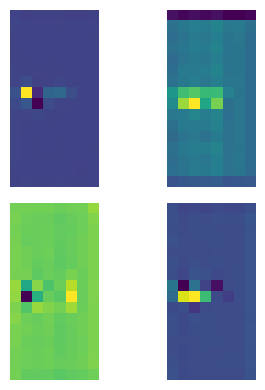

In [8]:
print(z_magnitude_db[:,0,:,:].shape)
heatmap_show([z_magnitude_db[:,0,:,:], z_magnitude_db[:,1,:,:], z_magnitude_db[:,2,:,:], z_magnitude_db[:,3,:,:]], grid_shape=None, titles=None, scale=0.5, cmap='viridis')

In [9]:
import torch
import torch.nn as nn
import timm

# Define the number of classes in your classification task
num_classes = 4  # Replace with your actual number of classes

# Instantiate EfficientNet-B4 from timm with pretrained weights
model = timm.create_model('efficientnet_b4', pretrained=True)


# Access the first convolutional layer
original_conv = model.conv_stem  # EfficientNet-B4 uses 'conv_stem' as the first layer

# Create a new convolutional layer with 320 input channels
new_conv = nn.Conv2d(
    in_channels=320,  # Your custom number of input channels
    out_channels=original_conv.out_channels,
    kernel_size=original_conv.kernel_size,
    stride=original_conv.stride,
    padding=original_conv.padding,
    bias=original_conv.bias is not None
)

# Initialize the weights of the new convolutional layer
# Option 1: Xavier Initialization
nn.init.xavier_uniform_(new_conv.weight)

# Optionally, initialize the bias if it exists
if original_conv.bias is not None:
    nn.init.zeros_(new_conv.bias)

# Replace the original convolutional layer with the new one
model.conv_stem = new_conv

# Replace the classifier with a new one matching the number of classes
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model.cuda()

print(model)


/project_ghent/Mostafa/ActivityRecognition/DistInference/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EfficientNet(
  (conv_stem): Conv2d(320, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

In [10]:
print(z_magnitude_db.shape)
zrand = torch.rand(1,320,32,32).cuda()
model(zrand)

torch.Size([1, 320, 16, 8])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 960, 1, 1])

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms

# Load EfficientNet-B4 with pre-trained weights
model = models.efficientnet_b4(pretrained=True)

# Modify the classifier to match the number of classes
num_classes = 4
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100

# Example training loop
for epoch in range(num_epochs):
    model.train()
    for feature_maps, labels in dataloader:
        feature_maps = feature_maps.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(feature_maps)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), "efficientnet_b4_rf_classifier.pth")


NameError: name 'dataloader' is not defined

In [ ]:
from DistInference.get_fold_dataloaders import get_dataloaders_from_config

config_path = '/project_ghent/Mostafa/ActivityRecognition/DistInference/src/DistInference/config.yaml'  # Path to your YAML config file
train_loader, val_loader, test_loader, fold_index = get_dataloaders_from_config(config_path)

print(f"Fold Index: {fold_index}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Example iteration
for i, (batch_data, batch_labels) in enumerate(train_loader):
    print("Batch index:", i, "Data shape:", batch_data.shape, "Labels:", batch_labels)
    # Perform training step...
    break  # Remove this to iterate through the entire DataLoader

Fold Index: 0
Number of training batches: 1120
Number of validation batches: 280
Number of test batches: 354
Batch index: 0 Data shape: torch.Size([1, 256, 80]) Labels: tensor([5])


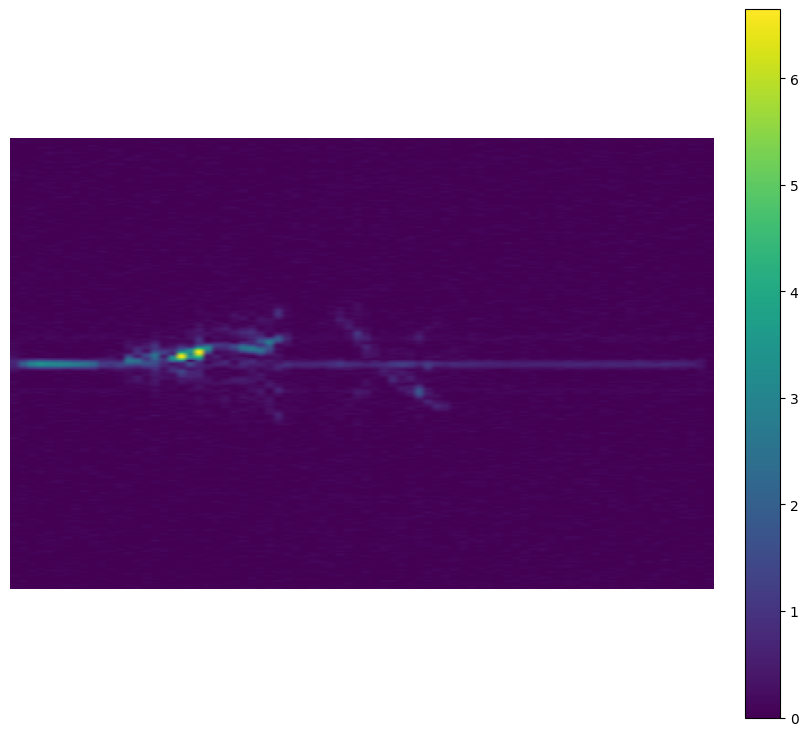

In [ ]:
heatmap_show([batch_data], scale=2, heatmap_aspect=.2)